In [12]:
import os
import itertools
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from PIL import Image

from CycleGAN import Generator, Discriminator


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [14]:
batch_size = 1
epochs = 200
lr = 2e-4

data_path = './data/apple2orange'
train_a_path = os.path.join(data_path, 'trainA')
train_b_path = os.path.join(data_path, 'trainB')
test_a_path = os.path.join(data_path, 'testA')
test_b_path = os.path.join(data_path, 'testB')
image_save_path = './images/cycleGAN'
model_save_path = './cycle_gan_apple2orange.pth'

os.makedirs(image_save_path, exist_ok=True)

In [15]:
class MyDataset(Dataset):
    def __init__(self, path, transform):
        super(MyDataset, self).__init__()
        self.image_paths = os.listdir(path)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        x = Image.open(image_path)
        x = self.transform(x)
        return x

In [16]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

all_dataset = datasets.ImageFolder(root=data_path, transform=transform)

train_a_indices = [idx for idx, target in enumerate(all_dataset.targets) if target is 0]
train_a_loader = DataLoader(Subset(all_dataset, train_a_indices), batch_size=batch_size, shuffle=True, num_workers=2)

train_b_indices = [idx for idx, target in enumerate(all_dataset.targets) if target is 1]
train_b_loader = DataLoader(Subset(all_dataset, train_b_indices), batch_size=batch_size, shuffle=True, num_workers=2)

test_a_indices = [idx for idx, target in enumerate(all_dataset.targets) if target is 2]
test_a_loader = DataLoader(Subset(all_dataset, test_a_indices), batch_size=batch_size, shuffle=True, num_workers=2)

test_b_indices = [idx for idx, target in enumerate(all_dataset.targets) if target is 3]
test_b_loader = DataLoader(Subset(all_dataset, test_b_indices), batch_size=batch_size, shuffle=True, num_workers=2)



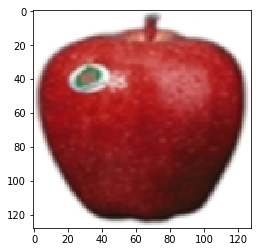

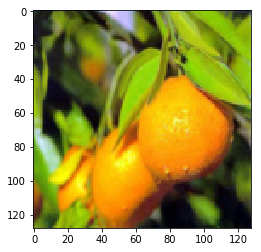

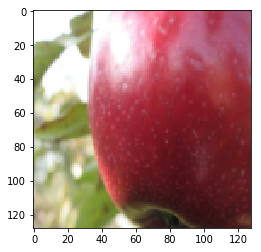

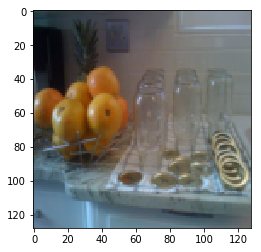

In [17]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, _ = next(iter(train_a_loader))
imshow(torchvision.utils.make_grid(images))

images, _ = next(iter(train_b_loader))
imshow(torchvision.utils.make_grid(images))

images, _ = next(iter(test_a_loader))
imshow(torchvision.utils.make_grid(images))

images, _ = next(iter(test_b_loader))
imshow(torchvision.utils.make_grid(images))

In [18]:
g_AB = Generator().to(device)
g_BA = Generator().to(device)
d_A = Discriminator().to(device)
d_B = Discriminator().to(device)
g_AB.train()
g_BA.train()
d_A.train()
d_B.train()

Discriminator(
  (b1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [19]:
print(g_AB)

Generator(
  (downsample1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (downsample4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (upsample1): Sequential(
    (0): Upsample(scale_factor=2.0, mo

In [20]:
print(d_A)

Discriminator(
  (b1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (b4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [21]:
real_label = 1.
fake_label = 0.

validation_weight = 1
reconstr_weight = 10
id_weight = 2

real_tensor = torch.ones(batch_size, 1, 16, 16).to(device)
fake_tensor = torch.zeros(batch_size, 1, 16, 16).to(device)

d_a_optimizer = optim.Adam(d_A.parameters(), lr=lr, betas=(0.5, 0.999))
d_b_optimizer = optim.Adam(d_B.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(itertools.chain(g_AB.parameters(), g_BA.parameters()), lr=lr, betas=(0.5, 0.999))

In [22]:
d_losses = []
g_losses = []
validation_losses = []
reconstr_losses = []
id_losses = []
d_accs = []

for epoch in range(epochs):
    epoch_validation_loss = 0.0
    epoch_reconstr_loss = 0.0
    epoch_id_loss = 0.0
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_d_acc = 0.0
    start_time = datetime.datetime.now()
    for (inputs_A, _), (inputs_B, _) in zip(train_a_loader, train_b_loader):
        inputs_A = inputs_A.to(device)
        inputs_B = inputs_B.to(device)
        
        fake_B = g_AB(inputs_A)
        fake_A = g_BA(inputs_B)
        
        # Discriminator
        d_a_optimizer.zero_grad()
        
        d_A_real_output = d_A(inputs_A)
        d_A_loss_real = nn.MSELoss()(d_A_real_output, real_tensor)
        d_A_acc_real = d_A_real_output.mean()
        d_A_fake_output = d_A(fake_A)
        d_A_loss_fake = nn.MSELoss()(d_A_fake_output, fake_tensor)
        d_A_acc_fake = 1. - d_A_real_output.mean()
        d_A_loss = 0.5 * (d_A_loss_real + d_A_loss_fake)
        d_A_acc = 0.5 * (d_A_acc_real + d_A_acc_fake)
        
        d_A_loss.backward()
        d_a_optimizer.step()
        
        d_b_optimizer.zero_grad()
        
        d_B_real_output = d_B(inputs_B)
        d_B_loss_real = nn.MSELoss()(d_B_real_output, real_tensor)
        d_B_acc_real = d_B_real_output.mean()
        d_B_fake_output = d_B(fake_B)
        d_B_loss_fake = nn.MSELoss()(d_B_fake_output, fake_tensor)
        d_B_acc_fake = 1. - d_B_fake_output.mean()
        d_B_loss = 0.5 * (d_B_loss_real + d_B_loss_fake)
        d_B_acc = 0.5 * (d_B_acc_real + d_B_acc_fake)

        d_B_loss.backward()
        d_b_optimizer.step()
        
        d_loss = 0.5 * (d_A_loss + d_B_loss)
        d_acc = 0.5 * (d_A_acc + d_B_acc) * 100
        
        # Generator
        g_optimizer.zero_grad()
        fake_B = g_AB(inputs_A)
        fake_A = g_BA(inputs_B)
        reconstr_A = g_BA(fake_B)
        reconstr_B = g_AB(fake_A)
        id_A = g_BA(inputs_A)
        id_B = g_AB(inputs_B)
        valid_A = d_A(fake_A)
        valid_B = d_B(fake_B)
        
        validation_loss = validation_weight * nn.MSELoss()(real_tensor, valid_A) +\
                          validation_weight * nn.MSELoss()(real_tensor, valid_B)
        reconstr_loss = reconstr_weight * nn.L1Loss()(inputs_A, reconstr_A) +\
                        reconstr_weight * nn.L1Loss()(inputs_B, reconstr_B)
        id_loss = id_weight * nn.L1Loss()(inputs_A, id_A) +\
                  id_weight * nn.L1Loss()(inputs_B, id_B)
        g_loss = validation_loss + reconstr_loss + id_loss
                 
        g_loss.backward()
        g_optimizer.step()
        
        
        epoch_d_loss += d_loss * inputs_A.size(0)
        epoch_g_loss += g_loss * inputs_A.size(0)
        epoch_validation_loss += validation_loss * inputs_A.size(0)
        epoch_reconstr_loss += reconstr_loss * inputs_A.size(0)
        epoch_id_loss += id_loss * inputs_A.size(0)
        epoch_d_acc += d_acc * inputs_A.size(0)
        
    num_data = len(train_a_indices)
    epoch_d_loss /= num_data
    epoch_g_loss /= num_data
    epoch_validation_loss /= num_data
    epoch_reconstr_loss /= num_data
    epoch_id_loss /= num_data
    epoch_d_acc /= num_data
    
    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)
    validation_losses.append(epoch_validation_loss)
    reconstr_losses.append(epoch_reconstr_loss)
    id_losses.append(epoch_id_loss)
    d_accs.append(epoch_d_acc)
        
    elapsed_time = datetime.datetime.now() - start_time
    print("[Epoch %d/%d] [D loss: %f, acc: %.2f%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s"\
        % (epoch, epochs,
           epoch_d_loss, epoch_d_acc,
           epoch_g_loss,
           epoch_validation_loss,
           epoch_reconstr_loss,
           epoch_id_loss,
           elapsed_time))
    
    if (epoch + 1) % 50 == 0:
        result_imgs = torch.cat([inputs_A, fake_B, reconstr_A, id_A,
                                 inputs_B, fake_A, reconstr_B, id_B], dim=0).detach().cpu()
        plt.figure(figsize=(20, 20))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(result_imgs,
                                                 nrow=4,
                                                 padding=2,
                                                 normalize=True), (1, 2, 0)))
        plt.savefig(os.path.join(image_save_path, 'result_img_e_{0}.png'.format(epoch + 1)))
        
        torch.save({'d_A': d_A.state_dict(),
                    'd_B': d_B.state_dict(),
                    'g_AB': g_AB.state_dict(),
                    'g_BA': g_BA.state_dict()},
                   model_save_path)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(20, 10))

plt.plot([x for x in d_losses], color='black', linewidth=0.1)
#plt.plot([x for x in g_losses], color='green', linewidth=0.1)
plt.plot([x for x in validation_losses], color='green', linewidth=0.1)
plt.plot([x for x in reconstr_losses], color='blue', linewidth=0.1)
plt.plot([x for x in id_losses], color='red', linewidth=0.1)

plt.xlabel('epoch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.ylim(0, 5)

plt.savefig(os.path.join(image_save_path, 'loss_graph.png'))